In [210]:
import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime as dt

#  <span style="color:darkred">1. Preprocessing </span>

##  <span style="color:indigo"> 1.1 Dataset observation </span>

In [183]:
#lecture du fichier .csv par la libraire Pandas
data=pd.read_csv('train.csv')
df=data.copy()
df_test=pd.read_csv('evaluation.csv')

#We need to separate X and Y
#X=data.loc[:,data.columns!="retweets_count"]
#Y=data['retweets_count']

In [222]:
timestamp=df["timestamp"][0]/1000
print(np.array(df["timestamp"]).shape)
date=dt.fromtimestamp(timestamp)
print(date.hour, date.minute, date.hour+date.minute/60)

(353969,)
6 54 6.9


## <span style="color:indigo">1.2 Features explanations </span>

df.quantile(0.99) #We check if there is a lot ludicrous values 

#If our dataset contains empty values, we put the mean value of the collum
if df.isnull().sum().sum()!=0: 
    imputer=SimpleImputer(missing_values=np.nan,strategy='mean')
else: 
    print("No missing_values in this dataset")


corr_matrix = df.corr()
plt.figure(figsize=(28,24))
sns.heatmap(data = corr_matrix,cmap='BrBG', annot=True, linewidths=0.2)

 ------> We observe that the only strong correlation that we can see at this time is the one between [favorite_count] 
and [retweet_count] , so we can already say that to predict the number of retweet, the number of favorite count is very important.

#checking for missing values in output
for i in range(df.shape[0]):
    if df['retweets_count'][i]==[]:
        print(df['retweets_count'][i])

## <span style="color:indigo">1.3 Normalisations </span>


On doit normaliser les données mais chaque colonne doit être normalisé différemment. 
- "favorites_count" -> moins de 1% de valeurs abhérantes (au top)
- "followers_count", -> Exponential 
- "statutes_count",
- "friends_count" -> moins de 1% de valeurs abhérantes (au top)


Normalization.quantile(0.999)

In [225]:
def get_time_into_df(df):
    result=pd.DataFrame(df,columns=["month", "day", "moment"])
    timestamps=np.array(df["timestamp"])
    
    for i in range(timestamps.shape[0]):
        date=dt.fromtimestamp(timestamps[i]/1000)
        result["month"][i]=date.month
        result["day"][i]=date.day
        result["moment"][i]=date.hour+date.minute/60
    return result

In [228]:
def myfunc(x):
     return np.log(1+x)

def Normaliser(df, df_test):
    
    column_names=["favorites_count","followers_count","statuses_count","friends_count"]
    
    #Create DFs and apply log to them
    
    Norm_train=pd.DataFrame(df,columns=["favorites_count","followers_count","statuses_count","friends_count"])
    Norm_train['favorites_count'] = Norm_train['favorites_count'].transform(myfunc)
    Norm_train['followers_count'] = Norm_train['followers_count'].transform(myfunc)
    Norm_train['friends_count'] = Norm_train['friends_count'].transform(myfunc)
    Norm_train['statuses_count'] = Norm_train['statuses_count'].transform(myfunc)
    
    Norm_rt=pd.DataFrame(df,columns=["retweets_count"])
    Norm_rt['retweets_count'] = Norm_rt['retweets_count'].transform(myfunc)
    
    Norm_test=pd.DataFrame(df_test,columns=["favorites_count","followers_count","statuses_count","friends_count"])
    Norm_test['favorites_count'] = Norm_test['favorites_count'].transform(myfunc)
    Norm_test['followers_count'] = Norm_test['followers_count'].transform(myfunc)
    Norm_test['friends_count'] = Norm_test['friends_count'].transform(myfunc)
    Norm_test['statuses_count'] = Norm_test['statuses_count'].transform(myfunc)
    
    #Also add time
    
    Time_train=get_time_into_df(df)
    Time_test=get_time_into_df(df_test)
    
    #Now rescale with min-max
    
    scaler_train=MinMaxScaler()
    scaler_train.fit(Norm_train)
    norm_train=scaler_train.transform(Norm_train)
    norm_test=scaler_train.transform(Norm_test)
    
    scaler_rt=MinMaxScaler()
    scaler_rt.fit(Norm_rt)
    norm_rt=scaler_rt.transform(Norm_rt)
    
    scaler_time=MinMaxScaler()
    scaler_time.fit(Time_train)
    norm_time_train=scaler_time.transform(Time_train)
    norm_time_test=scaler_time.transform(Time_test)
    
    #Now put the rescaled results into the original DFs
    
    Norm_train=pd.DataFrame(norm_train,columns=column_names)
    Norm_test=pd.DataFrame(norm_test,columns=column_names)
    Norm_rt=pd.DataFrame(norm_rt,columns=["retweets_count"])
    
    NormT_train=pd.DataFrame(norm_time_train,columns=["month", "day", "moment"])
    NormT_test=pd.DataFrame(norm_time_test,columns=["month", "day", "moment"])
    
    df['favorites_count']=Norm_train['favorites_count']
    df['followers_count']=Norm_train['followers_count'] 
    df['statuses_count']=Norm_train['statuses_count']
    df['friends_count']=Norm_train['friends_count']
    df['retweets_count']=Norm_rt['retweets_count']
    
    df_test['favorites_count']=Norm_test['favorites_count']
    df_test['followers_count']=Norm_test['followers_count'] 
    df_test['statuses_count']=Norm_test['statuses_count']
    df_test['friends_count']=Norm_test['friends_count']
    
    df["month"]=NormT_train["month"]
    df["day"]=NormT_train["day"]
    df["moment"]=NormT_train["moment"]
    
    df_test["month"]=NormT_test["month"]
    df_test["day"]=NormT_test["day"]
    df_test["moment"]=NormT_test["moment"]

    return df, df_test
    

In [230]:
df, df_test= Normaliser(df,df_test)

#  <span style="color:darkred">2. PCA Text and # treatment </span>


## <span style="color:indigo">2.1 Preprocessing of hashtags and texts </span>

In [185]:
#This is for hashtags

def most_important_hashtags(df, criteria):
    DICO2={} #DICO2 is for hashtags
    I=df.shape[0]
    for i in range(I):
        sentence=df["hashtags"][i][1:-1].replace(' ', '').split(',')
        for word in sentence:
            extracted_word=word[1:-1]
            if extracted_word in DICO2:
                DICO2[extracted_word]+=1
            else:
                DICO2[extracted_word]=1
    most_occurr_DICO2={}
    for word in DICO2:
        if DICO2[word]>criteria :#and word!=''
            most_occurr_DICO2[word]=0
    
    important_hashtags=list(most_occurr_DICO2.keys())
    
    measurer2={}
    for i in range(len(important_hashtags)):
        measurer2[important_hashtags[i]]=i
    measurer2
    return important_hashtags, measurer2

def make_array_training_hashtags(df, criteria):
    possibilities, measurer=most_important_hashtags(df, criteria)
    result=np.zeros((df.shape[0], len(possibilities)))
    for line in range(df.shape[0]):
        sentence=df["hashtags"][line][1:-1].replace(' ', '').split(',')
        for word in sentence:
            extracted_word=word[1:-1]
            if extracted_word in possibilities:
                result[line,measurer[extracted_word]]=1
                
    return result

def make_array_test_hashtags(df_test, criteria):
    possibilities, measurer=most_important_hashtags(df, criteria)
    result=np.zeros((df_test.shape[0], len(possibilities)))
    for line in range(df_test.shape[0]):
        sentence=df_test["hashtags"][line][1:-1].replace(' ', '').split(',')
        for word in sentence:
            extracted_word=word[1:-1]
            if extracted_word in possibilities:
                result[line,measurer[extracted_word]]=1
                
    return result

array_train_hashtags=make_array_training_hashtags(df,10)
array_test_hashtags=make_array_test_hashtags(df_test, 10)

In [186]:
#This is for texts

def most_important_words(df, criteria):
    DICO={}
    I=df.shape[0]
    for i in range(I):
        sentence=df["text"][i].split()
        for word in sentence:
            if word in DICO:
                DICO[word]+=1
            else:
                DICO[word]=1
            
    most_occurr_DICO={}
    for word in DICO:
        if DICO[word]>criteria:
            most_occurr_DICO[word]=0
    
    important_words=list(most_occurr_DICO.keys())
    measurer={}
    for i in range(len(important_words)):
        measurer[important_words[i]]=i
    measurer
    
    return important_words, measurer

def make_array_training_words(df, criteria):
    possibilities, measurer=most_important_words(df, criteria)
    result=np.zeros((df.shape[0], len(possibilities)))
    for line in range(df.shape[0]):
        sentence=df["text"][line].split()
        for word in sentence:
            if word in possibilities:
                result[line,measurer[word]]=1
                
    return result

def make_array_test_words(df_test, criteria):
    possibilities, measurer=most_important_words(df, criteria)
    result=np.zeros((df_test.shape[0], len(possibilities)))
    for line in range(df_test.shape[0]):
        sentence=df_test["text"][line].split()
        for word in sentence:
            if word in possibilities:
                result[line,measurer[word]]=1
                
    return result

array_train_text=make_array_training_words(df,5000)
array_test_text=make_array_test_words(df_test, 5000)


## <span style="color:indigo">2.2 PCA on words and hashtags: Understanding the main components of bags of words </span>


In [261]:
def PCA_training(array, n_comp):
    n=array.shape[1]
    for col in range(n):
        mean=np.mean(array[:,col])
        array[:,col]-=mean
            
    C=np.matmul(array.T,array)
    C/=array.shape[1]
    
    Lambda, Q=np.linalg.eigh(C)

    Qk=np.zeros((n,n_comp))
    for col in range(n_comp):
        Qk[:,col]=Q[:,n-col-1]
    return np.matmul(array,Qk), Qk

In [188]:
def PCA_test(training_array, test_array, n_comp):
    return np.matmul(test_array,PCA_training(training_array,n_comp)[1])

#  <span style="color:darkred">3. Preparing RNN on word sequences: Understanding relations between words </span>


## <span style="color:indigo"> 3.1 Pre-treatment for word embedding </span>

We will use the FastText method. We divide each word into groups of 3 letters (spaces are the "empty letter"). We keep the order in the text and make an embedding also using the adjacent words. For instance:
"macron demission"==> -ma,mac,acr,...,on-,n-d,-de,dem,... (- is the empty letter)

The fast text method will guess the adjacent 3 letters to each given patch of 3 letters. Hence for "mac" we want a high probability of "---" (3 times empty letter) and "ron". 

In [189]:
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

print(device)

cpu


In [190]:
#returns an array with the words in the sentence cut (n=3 that is in pieces of 3)

def cutter(sent, n):
    sentence=sent.split()
    length=len(sentence)+2-n
    for word in sentence:
        length+=len(word)
    result=[]
    padding=''
    for i in range(n):
        padding+=' '
    sent=' '+sent+' '
    padd_sent=padding+sent+padding
    
    for i in range(length):
        middle=sent[i:i+n]
        before=padd_sent[i:i+n]
        after=padd_sent[2*n+i:3*n+i]
        result.append([before, middle, after])
    return np.array(result)

In [191]:
n_alphabet=30

def batch_maker(size):
    X=np.zeros((size,3*n_alphabet))
    Y=np.zeros((size,6*n_alphabet))
    for i in range(size):
        
        line=random.randrange(0,350000)
        cut=cutter(df["text"][line],3)
        
        alphabet={
        ' ':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,
        'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'é':27,
        'è':28,
        #thus use mod 30 (as 29 is for any other letter (arabic...))
        }
        
        possibilities=[        
        ' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
        'y','z','é','è',]
        
        length=cut.shape[0]
        word_index=random.randrange(0,length)
        
        word0=cut[word_index, 0]
        word1=cut[word_index, 1]
        word2=cut[word_index, 2]
        for letter_ind in range(3):
            index0=0
            index1=0
            index2=0
            if (word0[letter_ind] not in possibilities):
                index0=29
            else:
                index0=alphabet[word0[letter_ind]]
                
            if (word1[letter_ind] not in possibilities):
                index1=29
            else:
                index1=alphabet[word1[letter_ind]]
                
            if (word2[letter_ind] not in possibilities):
                index2=29
            else:
                index2=alphabet[word2[letter_ind]]
                
            Y[i,letter_ind*n_alphabet+index0]=1
            X[i,letter_ind*n_alphabet+index1]=1
            Y[i,3*n_alphabet+letter_ind*n_alphabet+index2]=1
        
    return torch.tensor(X, requires_grad=True).float(),torch.tensor(Y, requires_grad=True).float()

In [248]:
batch_maker(100)[0].shape

torch.Size([100, 90])

## <span style="color:indigo"> 3.2 Encoder/decoder to mimic FastText</span>

This model takes a "word" (3 letters patch) as input and return a size 100 vector who is encoded to take into consideration the past and future patches

In [253]:
class embedd(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        #A sequential container: Modules will be added to it in the order they are passed in the constructor. 
        self.encoder=nn.Sequential(
            
        nn.Linear(3*n_alphabet,70,bias=True),
        nn.ReLU(),
        
        nn.Linear(70,45,bias=True),
        nn.Sigmoid())
        
        self.decoder=nn.Sequential(
        
        nn.Linear(45,110, bias=True),
        nn.ReLU(),
        
        nn.Linear(110,6*n_alphabet,bias=True),
        )
        
        #The forward() method of Sequential accepts 
        #any input and forwards it to the first module it contains.
        
    def forward(self, x):
        
        x=self.encoder(x)
        x=self.decoder(x)
        return x


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


KeyboardInterrupt: 

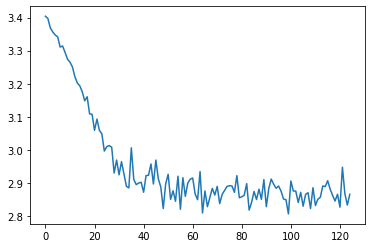

In [254]:
from pathlib import Path
# PARAMS

BATCH_SIZE=100 #1000
NUM_BACKWARDS=200
LEARNING_RATE=0.001

###############

loss_list=[]
Emb=embedd().to(device)
Emb.train()
optimizer = Adam(Emb.parameters(),lr=LEARNING_RATE)

for n in range(NUM_BACKWARDS):
    
    print(n)
    
    x,y_target=batch_maker(BATCH_SIZE)
    x = x.to(device) #we put the model and the variable on the gpu
    y=Emb(x)
    y = y.to(device)
    y_target = y_target.to(device) #because we use y_target after and we neet to put it on the gpu
    
    optimizer.zero_grad()
    loss_func=nn.CrossEntropyLoss()
    loss1_target = (y_target[:,:n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss2_target = (y_target[:,n_alphabet:2*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss3_target = (y_target[:,2*n_alphabet:3*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    
    loss4_target = (y_target[:,3*n_alphabet:4*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss5_target = (y_target[:,4*n_alphabet:5*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss6_target = (y_target[:,5*n_alphabet:6*n_alphabet] == 1).nonzero(as_tuple=True)[1]

    loss1=loss_func(y[:,:n_alphabet],loss1_target)
    loss2=loss_func(y[:,n_alphabet:2*n_alphabet],loss2_target)
    loss3=loss_func(y[:,2*n_alphabet:3*n_alphabet],loss3_target)
    
    loss4=loss_func(y[:,3*n_alphabet:4*n_alphabet],loss4_target)
    loss5=loss_func(y[:,4*n_alphabet:5*n_alphabet],loss5_target)
    loss6=loss_func(y[:,5*n_alphabet:6*n_alphabet],loss6_target)
    
    
    loss=(loss1+loss2+loss3+loss4+loss5+loss6)/6
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item()) #All this to update the loss plot
    fig, ax = plt.subplots()
    ax.plot(loss_list)
    fig.savefig("loss plot embedd bigbatch.png")
    plt.close(fig)
    
    if NUM_BACKWARDS%1000==0:
        torch.save(Emb.state_dict(),"Model.h5")
   

In [195]:
def find_output(Model, word):

    rev_alphabet={0:'_', 1:'a', 2:'b', 3:'c', 4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j',11:'k',12:'l',
                 13:'m',14:'n',15:'o',16:'p',17:'q',18:'r',19:'s',20:'t',21:'u',22:'v',23:'w',24:'x',
                 25:'y',26:'z',27:'é',28:'è',29:'others'}

    alphabet={
            ' ':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,
            'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'é':27,
            'è':28}

    possibilities=[        
            ' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
            'y','z','é','è',]

    inp=np.zeros((1,3*n_alphabet))
    for letter_ind in range(3):
        if word[letter_ind] in possibilities:
            inp[0,letter_ind*n_alphabet+alphabet[word[letter_ind]]]=1
        else:
            inp[0,letter_ind*n_alphabet+29]=1

    inp=torch.tensor(inp, requires_grad=True).float()
    y=Model(inp)

    y00=np.argmax(y[:,:n_alphabet].detach().numpy())
    y01=np.argmax(y[:,n_alphabet:2*n_alphabet].detach().numpy())
    y02=np.argmax(y[:,2*n_alphabet:3*n_alphabet].detach().numpy())
    y10=np.argmax(y[:,3*n_alphabet:4*n_alphabet].detach().numpy())
    y11=np.argmax(y[:,4*n_alphabet:5*n_alphabet].detach().numpy())
    y12=np.argmax(y[:,5*n_alphabet:6*n_alphabet].detach().numpy())

    before=rev_alphabet[y00]+rev_alphabet[y01]+rev_alphabet[y02]
    after=rev_alphabet[y10]+rev_alphabet[y11]+rev_alphabet[y12]

    return before, after

In [196]:
#Emb = embedd()
#Emb.load_state_dict(torch.load("C:/Users/feoni/OneDrive/Bureau/Polytechnique/ML/DeepLearning_Project/Model.h5"))
#Emb.eval()

find_output(Emb, "cro")
#Encoder avec plus de perceptron

('___', '___')

In [85]:
Emb.to(device)

embedd(
  (encoder): Sequential(
    (0): Linear(in_features=90, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=30, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=180, bias=True)
  )
)

In [86]:
Emb(x)

tensor([[ 0.7098, -0.1151, -0.9215,  ..., -0.7594, -3.2250, -2.5376],
        [ 1.6185,  0.0096, -0.4346,  ...,  0.1514, -2.4077, -2.6949],
        [ 2.4542, -0.6780, -1.0046,  ..., -0.5537, -2.7246, -3.5244],
        ...,
        [ 1.9367,  0.0643, -2.1337,  ..., -0.3473, -4.3823, -5.0206],
        [ 2.5790,  0.5447, -0.3419,  ...,  0.3784, -4.6896, -2.1500],
        [ 1.7655, -0.3340, -0.1127,  ..., -0.0254, -3.5908, -2.3545]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [200]:
def sentence_encoded(df, line):
    
    cut=cutter(df["text"][line],3)
    length=cut.shape[0]
    X=np.zeros((length,3*n_alphabet))
    
    alphabet={
        ' ':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,
        'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'é':27,
        'è':28,
        #thus use mod 30 (as 29 is for any other letter (arabic...))
        }
        
    possibilities=[        
        ' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
        'y','z','é','è',]

    for word_index in range(length):

        word=cut[word_index,1]
        inp=np.zeros(3*n_alphabet)

        for letter_ind in range(3):
            
            index=0

            if (word[letter_ind] not in possibilities):
                index0=29
            else:
                index0=alphabet[word[letter_ind]]
                

            X[word_index,letter_ind*n_alphabet+index0]=1

        
    return Emb.encoder(torch.tensor(X, requires_grad=True).float())#.to(device)

In [199]:
sentence_encoded(df, 2) #give the tensor of the complete embedded tweet (each 3 letter)

#sentence_encoded(3).shape
#30 for the alphabet size 
#the first argument is the tweet lenght

tensor([[0.6318, 0.5499, 0.6140, 0.5668, 0.5703, 0.6230, 0.4715, 0.4736, 0.5711,
         0.6080, 0.4908, 0.5881, 0.6227, 0.6069, 0.5859, 0.5568, 0.4563, 0.5723,
         0.5595, 0.5943, 0.5117, 0.5951, 0.5305, 0.5432, 0.5277, 0.4934, 0.5730,
         0.5742, 0.5926, 0.5404],
        [0.7790, 0.6595, 0.6985, 0.6642, 0.7030, 0.8029, 0.4665, 0.5161, 0.7502,
         0.7799, 0.5283, 0.7193, 0.8062, 0.7084, 0.7215, 0.7494, 0.4128, 0.7229,
         0.6588, 0.6919, 0.6458, 0.7514, 0.6553, 0.6331, 0.6818, 0.5810, 0.6707,
         0.7456, 0.7571, 0.6523],
        [0.7618, 0.6741, 0.7536, 0.7190, 0.6620, 0.7705, 0.4214, 0.5513, 0.7419,
         0.7272, 0.4995, 0.7578, 0.7774, 0.7779, 0.7628, 0.6701, 0.5320, 0.7337,
         0.7239, 0.7513, 0.7278, 0.7659, 0.6878, 0.6726, 0.7246, 0.6040, 0.6665,
         0.7220, 0.7642, 0.6930],
        [0.5970, 0.5698, 0.5946, 0.5441, 0.5342, 0.5829, 0.4845, 0.5170, 0.5186,
         0.5908, 0.5200, 0.5487, 0.5267, 0.5678, 0.5658, 0.5607, 0.5010, 0.5163,
       

#  <span style="color:darkred">4. NN coupled with RNN to find the rt </span>

In [262]:
n_feelings=5 #return of RNN part
n_mainstream=5+3 #followers, likes, verified... data that didn't get treated (no need) (after normalisation) +time
n_PCA_words=4 #after PCA on words
n_PCA_hashtag=3 #after PCA on hashtags

final_dim=n_feelings+n_mainstream+n_PCA_words+n_PCA_hashtag
final_dim

20

## <span style="color:indigo">4.1 RNN on embedded words: Understanding relations between words to extract a general opinion/feeling from the tweet</span>

In [202]:
class FeelingsFinder(nn.Module):
    
    def __init__(self,device):
        
        super().__init__()
        
        #RNN layer (30 for the input word vectors and 5 for the feeling vector of previous run)
        self.recurrNN=nn.RNN(30, n_feelings)
        #30 is the input vector and n_feelings the output vector
        self.lin=nn.Linear(n_feelings,n_feelings)
        #the rnn output 2 vectors : 1 output "normal" and one for the repetition
        #the two args need to have the same size because the layer is expected to receive a same size input 
        
    def forward(self,x): #x is a matrix of vectorised sentence
            
        #initialize first feeling vector 
        h=torch.zeros(1,n_feelings).to(device)
        
        #feed forward (x of shape (number of patches of 3, 100))
        for i in range(x.shape[0]):
            #we dont have to pay attention to the "h", because the thing we return is the "out" after it passed through the linear layer
            out, _ =self.recurrNN(x[i:i+1,:],h)
            out=self.lin(out)
            h=out
        
        return out

In [203]:
ff = FeelingsFinder("cuda:0").to(device)
ff

dummy_input = torch.rand((40, 30)).to(device)
dummy_input

print(ff(dummy_input).shape)

torch.Size([1, 5])


## <span style="color:indigo">4.2 NN to find out rt: takes as input the output of RNN & all the treated dimensions above (2 PCAs, normalised mainstream dimensions...)</span>

In [204]:
class RTFinder(nn.Module):
    
    def __init__(self,device):
        
        super().__init__()
        
        self.NN=nn.Sequential(
        
        nn.Linear(final_dim,10,bias=True),
        nn.ReLU(True),
            
        nn.Linear(10,4,bias=True),
        nn.ReLU(True),
        
        nn.Linear(4,1, bias=True),
        nn.Sigmoid())
        
        self.feelings_finder = FeelingsFinder("cuda:0").to(device)
        
    def forward(self, x, y): #x is concatenatioon of all dimensions and y same as x in forward of FeelingsFinder
        
        return self.NN(torch.cat((x.T,self.feelings_finder(y).T)).T)
        

In [205]:
dummy_input = torch.rand((40, 30)).to(device)

RT= RTFinder("cuda:0").to(device)

dummy_input2 = torch.rand((1, 11)).to(device)
dummy_input3 = torch.rand((1, 11)).to(device)

#print(torch.cat((dummy_input2.T, dummy_input3.T)).T.shape)
print(RT(dummy_input2, dummy_input))

AssertionError: Torch not compiled with CUDA enabled

In [273]:
def data_to_train(line):
    concat_data=np.zeros((1, 15))
    concat_data[0,0]=df["favorites_count"][line]
    concat_data[0,1]=df["followers_count"][line]
    concat_data[0,2]=df["friends_count"][line]
    concat_data[0,3]=df["statuses_count"][line]
    concat_data[0,4]=df["verified"][line]
    concat_data[0,5]=df["month"][line]
    concat_data[0,6]=df["day"][line]
    concat_data[0,7]=df["moment"][line]
    
    #try to define the most important words so no need to redefine them later
    
    PCA_text=PCA_training(array_train_text,4)[0][line,:]
    concat_data[0,8:12]=PCA_text
    
    PCA_hashtag=PCA_training(array_train_hashtags,3)[0][line,:]
    concat_data[0,12:15]=PCA_hashtag
    
    return torch.tensor(concat_data).float(), sentence_encoded(df, line)

In [274]:
data_to_train(10)

(tensor([[ 0.0000,  0.6174,  0.7047,  0.8673,  0.0000,  0.1818,  0.4667,  0.4844,
          -0.2490, -0.1701,  0.1340,  0.3202,  0.1854,  0.0083,  0.0022]]),
 tensor([[0.5338, 0.5873, 0.5199,  ..., 0.5088, 0.5851, 0.5890],
         [0.6137, 0.6587, 0.5689,  ..., 0.5270, 0.6280, 0.6703],
         [0.5712, 0.6200, 0.5121,  ..., 0.5128, 0.5971, 0.6053],
         ...,
         [0.6598, 0.7306, 0.5928,  ..., 0.5418, 0.7118, 0.7265],
         [0.6048, 0.6294, 0.4940,  ..., 0.4988, 0.5953, 0.6436],
         [0.5104, 0.5490, 0.4892,  ..., 0.5130, 0.5443, 0.5634]],
        grad_fn=<SigmoidBackward0>))

In [181]:
#Training loop (train for each line)

RT=RTFinder("cuda:0").to(device)
progressbar = tqdm(range(35000))
loss=None
loss_list=[]

optimizer = Adam(RT.parameters(),lr=0.001)

for line in progressbar:
    print(line)
    if loss is None:
        optimizer.zero_grad()
    x0, x1 = data_to_train(line)
    x0 = x0.to(device)
    x1 = x1.to(device)
    rt=RT(x0, x1)
    rt_target=df["retweets_count"][line]
    rt_target = torch.tensor(rt_target).to(device)
    loss_func=nn.MSELoss()
    
    if loss is None:
        loss=loss_func(rt, torch.tensor(rt_target).float())
    else:
        loss+=loss_func(rt, torch.tensor(rt_target).float())
    
    if line%500==0 and line!=0:
        line/=500
        torch.save(Emb.state_dict(),"Final_Network.h5")
        
        loss_list.append(loss.item()) #All this to update the loss plot
        fig, ax = plt.subplots()
        ax.plot(loss_list)
        fig.savefig("loss plot.png")
        plt.close(fig)
        
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item(): .6f}")
        #progressbar.set_description(f"Loss: {loss.item(): .6f}")
        loss=None

NameError: name 'RTFinder' is not defined

#  <span style="color:darkred">5. Apply everything onto test dataset </span>

## <span style="color:indigo">5.1 Prepare test data</span>

In [127]:
df_test=pd.read_csv('evaluation.csv')

In [178]:
df_test=Normaliser(df, df_test)[1]

In [277]:
def data_to_test(line):
    concat_data=np.zeros((1,15))
    concat_data[0,0]=df_test["favorites_count"][line]
    concat_data[0,1]=df_test["followers_count"][line]
    concat_data[0,2]=df_test["friends_count"][line]
    concat_data[0,3]=df_test["statuses_count"][line]
    concat_data[0,4]=df_test["verified"][line]
    concat_data[0,5]=df_test["month"][line]
    concat_data[0,6]=df_test["day"][line]
    concat_data[0,7]=df_test["moment"][line]
    
    PCA_text=PCA_test(array_train_text,array_test_text,4)[line,:]
    concat_data[0,8:12]=PCA_text
    
    PCA_hashtag=PCA_test(array_train_hashtags,array_test_hashtags,3)[line,:]
    concat_data[0,12:15]=PCA_hashtag
    
    return torch.tensor(concat_data).float(), sentence_encoded(df_test, line)

In [278]:
data_to_test(10)

(tensor([[ 0.0000,  0.4784,  0.6956,  0.7490,  0.0000,  0.1818,  0.4333,  0.6095,
          -0.2672,  0.7977, -0.9882, -0.4286,  0.9586,  0.2287,  0.1284]]),
 tensor([[0.6038, 0.6599, 0.5267,  ..., 0.5169, 0.6527, 0.6630],
         [0.5199, 0.5452, 0.5117,  ..., 0.5204, 0.5313, 0.5580],
         [0.5245, 0.5361, 0.5000,  ..., 0.5035, 0.5449, 0.5595],
         ...,
         [0.5749, 0.6163, 0.5218,  ..., 0.5286, 0.6239, 0.6370],
         [0.5540, 0.5622, 0.5204,  ..., 0.5110, 0.5730, 0.6113],
         [0.4974, 0.5407, 0.4867,  ..., 0.5145, 0.5320, 0.5514]],
        grad_fn=<SigmoidBackward0>))

## <span style="color:indigo">5.2 Predict on the test data</span>

Loss function : Mean Absolute Error (MAE) ->
The MAE metric is calculated by dividing the sum of absolute differences between the predicted
number of retweets (pi) and the observed number of retweets (ai) by the number of observations
(N), i

In [ ]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [ ]:
eval=mae(Y,predictions)
print(eval)